In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import os
import json

from transformers import AutoModel # For BERTs
from transformers import AutoModelForSequenceClassification
import torch

import time

from tqdm import tqdm

In [3]:
###setting directory
data_dir="data"
model_dir="models"
output_dir="output"
###

# Read Motivations and Prediction

In [4]:
#prediction=pd.read_csv('prediction/paper 1 model/result covid without project/result_covid.csv')
prediction=pd.read_csv('prediction/paper 1 model/result covid with project/result_covid.csv')

In [5]:
prediction.columns

Index(['opinion', 'project', 'Be creative', 'Be curious',
       'Have freedom of thought', 'Be choosing own goals', 'Be independent',
       'Have freedom of action', 'Have privacy', 'Have an exciting life',
       'Have a varied life', 'Be daring', 'Have pleasure', 'Be ambitious',
       'Have success', 'Be capable', 'Be intellectual', 'Be courageous',
       'Have influence', 'Have the right to command', 'Have wealth',
       'Have social recognition', 'Have a good reputation',
       'Have a sense of belonging', 'Have good health', 'Have no debts',
       'Be neat and tidy', 'Have a comfortable life', 'Have a safe country',
       'Have a stable society', 'Be respecting traditions',
       'Be holding religious faith', 'Be compliant', 'Be self-disciplined',
       'Be behaving properly', 'Be polite', 'Be honoring elders', 'Be humble',
       'Have life accepted as is', 'Be helpful', 'Be honest', 'Be forgiving',
       'Have the own family secured', 'Be loving', 'Be responsible',
  

In [6]:
prediction_summary=prediction[['Be creative', 'Be curious',
       'Have freedom of thought', 'Be choosing own goals', 'Be independent',
       'Have freedom of action', 'Have privacy', 'Have an exciting life',
       'Have a varied life', 'Be daring', 'Have pleasure', 'Be ambitious',
       'Have success', 'Be capable', 'Be intellectual', 'Be courageous',
       'Have influence', 'Have the right to command', 'Have wealth',
       'Have social recognition', 'Have a good reputation',
       'Have a sense of belonging', 'Have good health', 'Have no debts',
       'Be neat and tidy', 'Have a comfortable life', 'Have a safe country',
       'Have a stable society', 'Be respecting traditions',
       'Be holding religious faith', 'Be compliant', 'Be self-disciplined',
       'Be behaving properly', 'Be polite', 'Be honoring elders', 'Be humble',
       'Have life accepted as is', 'Be helpful', 'Be honest', 'Be forgiving',
       'Have the own family secured', 'Be loving', 'Be responsible',
       'Have loyalty towards friends', 'Have equality', 'Be just',
       'Have a world at peace', 'Be protecting the environment',
       'Have harmony with nature', 'Have a world of beauty', 'Be broadminded',
       'Have the wisdom to accept others', 'Be logical',
       'Have an objective view']].sum()

In [7]:
prediction_summary

Be creative                           220
Be curious                           2638
Have freedom of thought               156
Be choosing own goals                4025
Be independent                        921
Have freedom of action                768
Have privacy                            0
Have an exciting life                   0
Have a varied life                      3
Be daring                               0
Have pleasure                           3
Be ambitious                         6771
Have success                            5
Be capable                              3
Be intellectual                         0
Be courageous                           0
Have influence                         70
Have the right to command               5
Have wealth                          2784
Have social recognition                44
Have a good reputation               6066
Have a sense of belonging               0
Have good health                       33
Have no debts                     

In [8]:
prediction_summary.index

Index(['Be creative', 'Be curious', 'Have freedom of thought',
       'Be choosing own goals', 'Be independent', 'Have freedom of action',
       'Have privacy', 'Have an exciting life', 'Have a varied life',
       'Be daring', 'Have pleasure', 'Be ambitious', 'Have success',
       'Be capable', 'Be intellectual', 'Be courageous', 'Have influence',
       'Have the right to command', 'Have wealth', 'Have social recognition',
       'Have a good reputation', 'Have a sense of belonging',
       'Have good health', 'Have no debts', 'Be neat and tidy',
       'Have a comfortable life', 'Have a safe country',
       'Have a stable society', 'Be respecting traditions',
       'Be holding religious faith', 'Be compliant', 'Be self-disciplined',
       'Be behaving properly', 'Be polite', 'Be honoring elders', 'Be humble',
       'Have life accepted as is', 'Be helpful', 'Be honest', 'Be forgiving',
       'Have the own family secured', 'Be loving', 'Be responsible',
       'Have loyalty tow

In [9]:
prediction_value=[]
prediction_count=[]
for index, value in prediction_summary.items():
    prediction_value.append(index)
    prediction_count.append(value)

# Automation (Topic modelling)

In [10]:
import nltk
import gensim
import gensim.corpora as corpora
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from gensim.models.coherencemodel import CoherenceModel

from sklearn.model_selection import train_test_split

In [11]:
PVE_input, test = train_test_split(prediction, test_size=0.95, random_state=42)


#PVE_input=prediction

In [12]:
#create a function that execute all the topic modelling process

import re 
from bertopic.representation import MaximalMarginalRelevance
def topic_by_value(value_input, prediction_input, text_input, umap_n_neighbors=15, umap_n_components=5,HDBSCAN_min_cluster_size=30,HDBSCAN_min_samples=30):

    ######################################################
    #Creating a dataframe from the data imported 
    full_train = pd.DataFrame() 
    full_train['text'] = text_input #PVE_covid['train']['opinion']

    #only selected the text with selected value prediction
    full_train=full_train[prediction_input[value_input]==1].copy() #prediction_trimmed, 'Achievement'

    full_train['text'] = full_train['text'].fillna('').astype(str) #removing any nan type objects
    full_train.head()
    documents = full_train
    
    filtered_text = []
    lemmatizer = WordNetLemmatizer()
    ######################################################
    for w in documents['text']:
        #filtered_text.append(lemmatizer.lemmatize(w))
        tokens = nltk.word_tokenize(w)
        #filtered_text.append(" ".join([lemmatizer.lemmatize(tok) for tok in tokens]))
        sent=" ".join([lemmatizer.lemmatize(tok) for tok in tokens])
        #sent=re.sub(' \,', ',', sent)
        #sent=re.sub(' \.', '.', sent)
        #sent=re.sub(' \?', '?', sent)
        #sent=re.sub(' \!', '!', sent)
        filtered_text.append(sent)

    ######################################################
    # Step 2.1 - Extract embeddings
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    # Step 2.2 - Reduce dimensionality
    umap_model = UMAP(umap_n_neighbors, umap_n_components, min_dist=0.0, metric='cosine', random_state=42)
    # Step 2.3 - Cluster reduced embeddings
    hdbscan_model = HDBSCAN(HDBSCAN_min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True,min_samples=HDBSCAN_min_samples)
    # Step 2.4 - Tokenize topics
    vectorizer_model = CountVectorizer(stop_words="english")
    # Step 2.5 - Create topic representation
    ctfidf_model = ClassTfidfTransformer()
    ##################################################################################
    representation_model = MaximalMarginalRelevance(diversity=0.2)
    ##################################################################################    
    topic_model = BERTopic(
    embedding_model=embedding_model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    #diversity=0.5,
    representation_model=representation_model,
    #representation_model = OpenAI(model="gpt-3.5-turbo", delay_in_seconds=10, chat=True),
    #representation_model = OpenAI(),
    nr_topics=10                        #Step 6 - Diversify topic words
    )
    
    
    topics, probabilities = topic_model.fit_transform(filtered_text)

    return (topic_model, filtered_text)


In [13]:
value_simplified = {
'Self-direction: thought': {'Self-direction'},
'Self-direction: action':{ 'Self-direction'},
'Stimulation':{'Stimulation'},
'Hedonism':{'Hedonism'} ,
'Achievement':{'Achievement'},
'Power: dominance':{'Power'}, 
'Power: resources':{'Power'},  
'Face':{'Face'},
'Security: personal':{'Security'}, 
'Security: societal':{'Security'},           
'Tradition':{'Tradition'},
'Conformity: rules':{'Conformity'},            
'Conformity: interpersonal':{'Conformity'},            
'Humility':{'Humility'},             
'Benevolence: caring':{'Benevolence'}, 
'Benevolence: dependability':{'Benevolence'},
'Universalism: concern':{'Universalism'}, 
'Universalism: nature':{'Universalism'},
'Universalism: tolerance':{'Universalism'},
'Universalism: objectivity':{'Universalism'}
}
value_l2 = {
'Be creative': {'Self-direction: thought'},
'Be curious': {'Self-direction: thought'},
'Have freedom of thought': {'Self-direction: thought'},
'Be choosing own goals': {'Self-direction: action'},
'Be independent': {'Self-direction: action'},
'Have freedom of action': {'Self-direction: action'},
'Have privacy': {'Self-direction: action'},
'Have an exciting life': {'Stimulation'},
'Have a varied life': {'Stimulation'},
'Be daring': {'Stimulation'},
'Have pleasure': {'Hedonism'},
'Be ambitious': {'Achievement'},
'Have success': {'Achievement'},
'Be capable': {'Achievement'},
'Be intellectual': {'Achievement'},
'Be courageous': {'Achievement'},
'Have influence': {'Power: dominance'},
'Have the right to command': {'Power: dominance'},
'Have wealth': {'Power: resources'},
'Have social recognition': {'Face'},
'Have a good reputation': {'Face'},
'Have a sense of belonging': {'Security: personal'},
'Have good health': {'Security: personal'},
'Have no debts': {'Security: personal'},
'Be neat and tidy': {'Security: personal'},
'Have a comfortable life': {'Security: personal'},
'Have a safe country': {'Security: societal'},
'Have a stable society': {'Security: societal'},
'Be respecting traditions': {'Tradition'},
'Be holding religious faith': {'Tradition'},
'Be compliant': {'Conformity: rules'},
'Be self-disciplined': {'Conformity: rules'},
'Be behaving properly': {'Conformity: rules'},
'Be polite': {'Conformity: interpersonal'},
'Be honoring elders': {'Conformity: interpersonal'},
'Be humble': {'Humility'},
'Have life accepted as is': {'Humility'},
'Be helpful': {'Benevolence: caring'},
'Be honest': {'Benevolence: caring'},
'Be forgiving': {'Benevolence: caring'},
'Have the own family secured': {'Benevolence: caring'},
'Be loving': {'Benevolence: caring'},
'Be responsible': {'Benevolence: dependability'},
'Have loyalty towards friends': {'Benevolence: dependability'},
'Have equality': {'Universalism: concern'},
'Be just': {'Universalism: concern'},
'Have a world at peace': {'Universalism: concern'},
'Be protecting the environment': {'Universalism: nature'},
'Have harmony with nature': {'Universalism: nature'},
'Have a world of beauty': {'Universalism: nature'},
'Be broadminded': {'Universalism: tolerance'},
'Have the wisdom to accept others': {'Universalism: tolerance'},
'Be logical': {'Universalism: objectivity'},
'Have an objective view': {'Universalism: objectivity'}}


In [14]:
def topic_by_value_automate(value):
    try:
        topic_model, filtered_text=topic_by_value(value,prediction,PVE_input['opinion'])
        for j in range(topic_model.get_topic_info().shape[0]-1):
            print(([topic_model.topic_representations_[j][i][0] for i in range(5)]))
            #raw_context_value_list[value+'_'+str(j)]=[set([value]),set([topic_model.topic_representations_[j][i][0] for i in range(5)])]
            #from top 5 words to top 3 words
            raw_context_value_list[value+'_'+str(j)]=[set([value]),set([topic_model.topic_representations_[j][i][0] for i in range(10)]),set(topic_model.representative_docs_[j]),value_l2[value]]
        #value_count.append(list(topic_model.get_topic_info()['Count'][1:]))
        if list(topic_model.get_topic_info()['Count'][1:]) != []:
            value_count.extend(list(topic_model.get_topic_info()['Count'][1:]))
            #topic_embeddings.extend(topic_model.topic_embeddings_[1:])
    except:
        print('Error')

In [15]:
raw_context_value_list={}
#topic_embeddings=[]
value_count=[]
for i in ['Be creative', 'Be curious', 'Have freedom of thought',
       'Be choosing own goals', 'Be independent', 'Have freedom of action',
       'Have privacy', 'Have an exciting life', 'Have a varied life',
       'Be daring', 'Have pleasure', 'Be ambitious', 'Have success',
       'Be capable', 'Be intellectual', 'Be courageous', 'Have influence',
       'Have the right to command', 'Have wealth', 'Have social recognition',
       'Have a good reputation', 'Have a sense of belonging',
       'Have good health', 'Have no debts', 'Be neat and tidy',
       'Have a comfortable life', 'Have a safe country',
       'Have a stable society', 'Be respecting traditions',
       'Be holding religious faith', 'Be compliant', 'Be self-disciplined',
       'Be behaving properly', 'Be polite', 'Be honoring elders', 'Be humble',
       'Have life accepted as is', 'Be helpful', 'Be honest', 'Be forgiving',
       'Have the own family secured', 'Be loving', 'Be responsible',
       'Have loyalty towards friends', 'Have equality', 'Be just',
       'Have a world at peace', 'Be protecting the environment',
       'Have harmony with nature', 'Have a world of beauty', 'Be broadminded',
       'Have the wisdom to accept others', 'Be logical',
       'Have an objective view']:
    print(i)
    topic_by_value_automate(i)

Be creative
Error
Be curious
Have freedom of thought
Error
Be choosing own goals
['company', 'work', 'economy', 'economic', 'catering']
['profession', 'hairdresser', 'work', 'glove', 'dentist']
Be independent
Have freedom of action
Have privacy
Error
Have an exciting life
Error
Have a varied life
Error
Be daring
Error
Have pleasure
Error
Be ambitious
Have success
Error
Be capable
Error
Be intellectual
Error
Be courageous
Error
Have influence
Error
Have the right to command
Error
Have wealth
['profession', 'measure', 'income', 'company', 'customer']
['young', 'distance', 'risk', 'measure', 'virus']
Have social recognition
Error
Have a good reputation
['elderly', 'nursing', 'family', 'visit', 'loneliness']
['family', 'contact', 'distance', 'meter', 'group']
Have a sense of belonging
Error
Have good health
Error
Have no debts
Error
Be neat and tidy
Have a comfortable life
Have a safe country
Error
Have a stable society
['elderly', 'nursing', 'family', 'loneliness', 'visit']
Be respecting 

In [16]:
len(raw_context_value_list)

19

In [17]:
raw_context_value_list

{'Be choosing own goals_0': [{'Be choosing own goals'},
  {'catering',
   'company',
   'economic',
   'economics',
   'economy',
   'employee',
   'employment',
   'measure',
   'meter',
   'work'},
  {'A large part of the Dutch company are now close , but a large part of these company are poorly able to work at home . I think that company that are not dealing with external customer and therefore have a fixed workforce should be open again , both for the economy and for mental health care . You could consider setting up shift service , so that fewer employee are present at the same time . Meetings and meeting could stay online , a well a carrying out work that can be done from home . Example : I work at a research laboratory . Essential is the carrying out of experiment . The data obtained could be worked out at home and the design of the experiment could also be done from home .',
   'In many company , it is possible to introduce 1.5 distance and where working at home is difficult . 

In [18]:
value_count

[49, 53, 38, 33, 133, 156, 572, 90, 74, 84, 90, 54, 71, 60, 64, 60, 87, 37, 46]

# Comparison of draft values

In [19]:
def get_vectors(phrases, model):
    """ Embed phrases with SentenceTransformer model.
    """
    return np.array(model.encode(phrases), dtype=np.float)

In [20]:
from sklearn.preprocessing import normalize
def compute_center(value, model, context_value_list ):
    
    """ Get the value cluster center as the normalized sum of the embeddings of the keywords + value name.
    """
    # Get value and keywords.
    keywords = list(context_value_list[value][1])

    # Embed all keywords and value key and take the normalized sum as center.
    vectors = get_vectors(keywords, model)
    center  = normalize([np.sum(vectors, axis=0)])[0]

    return center

In [21]:
#select model that provide embedding for words
if torch.cuda.is_available():
    model_keywords_distance=SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
else:
    model_keywords_distance=SentenceTransformer('all-MiniLM-L6-v2')   


In [22]:
#get cosine distance from a pair of values

from scipy.spatial.distance import cdist
def get_distance(centre1, centre2):
    a=np.expand_dims(centre1, axis=0)
    b=np.expand_dims(centre2, axis=0)
    return float(np.absolute(cdist(a,b, 'cosine'))[0])

In [23]:
raw_context_value_list.keys()

dict_keys(['Be choosing own goals_0', 'Be choosing own goals_1', 'Have wealth_0', 'Have wealth_1', 'Have a good reputation_0', 'Have a good reputation_1', 'Have a stable society_0', 'Be compliant_0', 'Be compliant_1', 'Be helpful_0', 'Have the own family secured_0', 'Have the own family secured_1', 'Have the own family secured_2', 'Have the own family secured_3', 'Be broadminded_0', 'Be broadminded_1', 'Be broadminded_2', 'Have an objective view_0', 'Have an objective view_1'])

In [24]:
topic_embeddings=[]
for i in raw_context_value_list.keys():
    topic_embeddings.append(compute_center(i, model_keywords_distance, raw_context_value_list ))

In [25]:
len(topic_embeddings)

19

In [26]:
cosine_list=pd.DataFrame()

for i ,iv in enumerate(raw_context_value_list):
    #print(iv)
    score_list=[]
    for j ,jv in enumerate(raw_context_value_list):
        #print(jv)
        if i==j:
            score_list.append(np.nan)
        else:
            score_list.append(get_distance(topic_embeddings[i], topic_embeddings[j]))
    cosine_list[iv]=pd.Series(score_list)

In [27]:
cosine_list['index']=raw_context_value_list.keys()
cosine_list=cosine_list.set_index('index')

In [28]:
cosine_list

,Be choosing own goals_0,Be choosing own goals_1,Have wealth_0,Have wealth_1,Have a good reputation_0,Have a good reputation_1,Have a stable society_0,Be compliant_0,Be compliant_1,Be helpful_0,Have the own family secured_0,Have the own family secured_1,Have the own family secured_2,Have the own family secured_3,Be broadminded_0,Be broadminded_1,Be broadminded_2,Have an objective view_0,Have an objective view_1
index,,,,,,,,,,,,,,,,,,,
Be choosing own goals_0,NaN,0.271603,0.081505,0.298924,0.364553,0.281648,0.380951,0.291339,0.322687,0.302948,0.343971,0.485376,0.340397,0.162777,0.298411,0.323383,0.358079,0.291290,0.138954
Be choosing own goals_1,0.271603,NaN,0.275867,0.380887,0.362113,0.369115,0.381464,0.322598,0.360806,0.342438,0.051493,0.444168,0.358191,0.312946,0.416386,0.356873,0.359569,0.446840,0.322048
Have wealth_0,0.081505,0.275867,NaN,0.331345,0.353878,0.285831,0.381752,0.259466,0.307224,0.292916,0.324773,0.456406,0.346223,0.148920,0.323556,0.303165,0.358073,0.227188,0.101654
Have wealth_1,0.298924,0.380887,0.331345,NaN,0.351236,0.127160,0.361029,0.202942,0.292547,0.160210,0.357675,0.329150,0.307615,0.273610,0.126500,0.321457,0.338204,0.343416,0.350342
Have a good reputation_0,0.364553,0.362113,0.353878,0.351236,NaN,0.244423,0.058023,0.297591,0.192254,0.178956,0.323124,0.342358,0.101749,0.302249,0.371520,0.207619,0.080795,0.389967,0.355582
Have a good reputation_1,0.281648,0.369115,0.285831,0.127160,0.244423,NaN,0.273597,0.255754,0.144573,0.133978,0.326114,0.336819,0.235920,0.255519,0.133484,0.176991,0.252251,0.356240,0.298021
Have a stable society_0,0.380951,0.381464,0.381752,0.361029,0.058023,0.273597,NaN,0.307933,0.203738,0.204314,0.368282,0.295832,0.076174,0.281870,0.394991,0.199736,0.038506,0.371025,0.376259
Be compliant_0,0.291339,0.322598,0.259466,0.202942,0.297591,0.255754,0.307933,NaN,0.206169,0.184842,0.338067,0.337852,0.254318,0.194683,0.314776,0.260934,0.271361,0.285206,0.282302
Be compliant_1,0.322687,0.360806,0.307224,0.292547,0.192254,0.144573,0.203738,0.206169,NaN,0.157448,0.331575,0.317632,0.151937,0.202807,0.319080,0.097403,0.153794,0.359911,0.309286


In [29]:
from pylab import rcParams
import seaborn as sb
import matplotlib.pyplot as plt

<Axes: ylabel='index'>

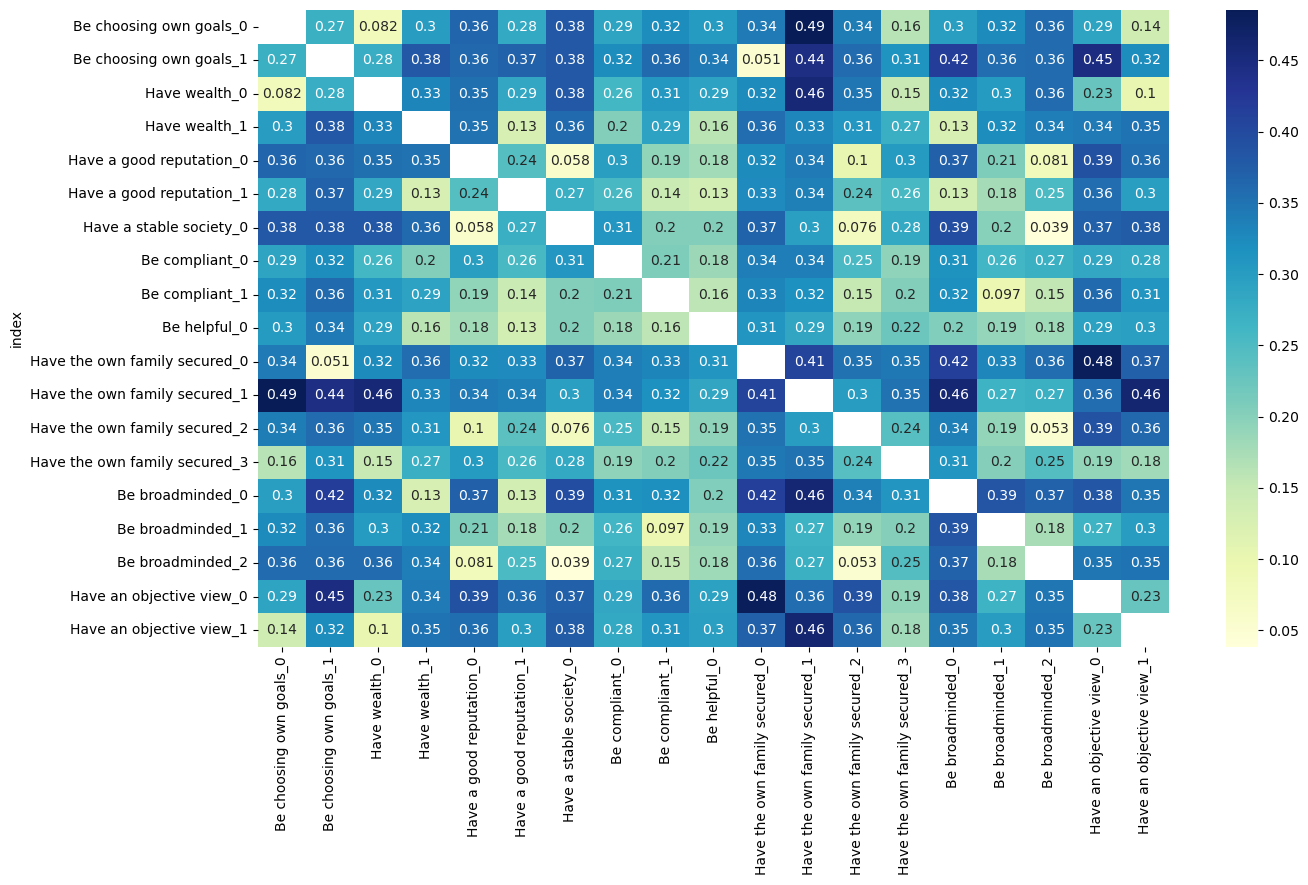

In [30]:
rcParams['figure.figsize'] = 14.7,8.27
sb.heatmap(cosine_list,
           #yticklabels=raw_context_value_list.keys(), 
           #xticklabels=raw_context_value_list.keys(), 
           cmap="YlGnBu",
          annot=True)

In [31]:
cosine_list_dedup=[]

for i ,iv in enumerate(raw_context_value_list):
    #print(iv)
    score_list=[]
    for j ,jv in enumerate(raw_context_value_list):
        #print(jv)
        if i<j:
            cosine_list_dedup.append(get_distance(topic_embeddings[i], topic_embeddings[j]))


In [32]:
len(cosine_list_dedup)

171

In [33]:
cosine_list_dedup.sort(reverse=True)

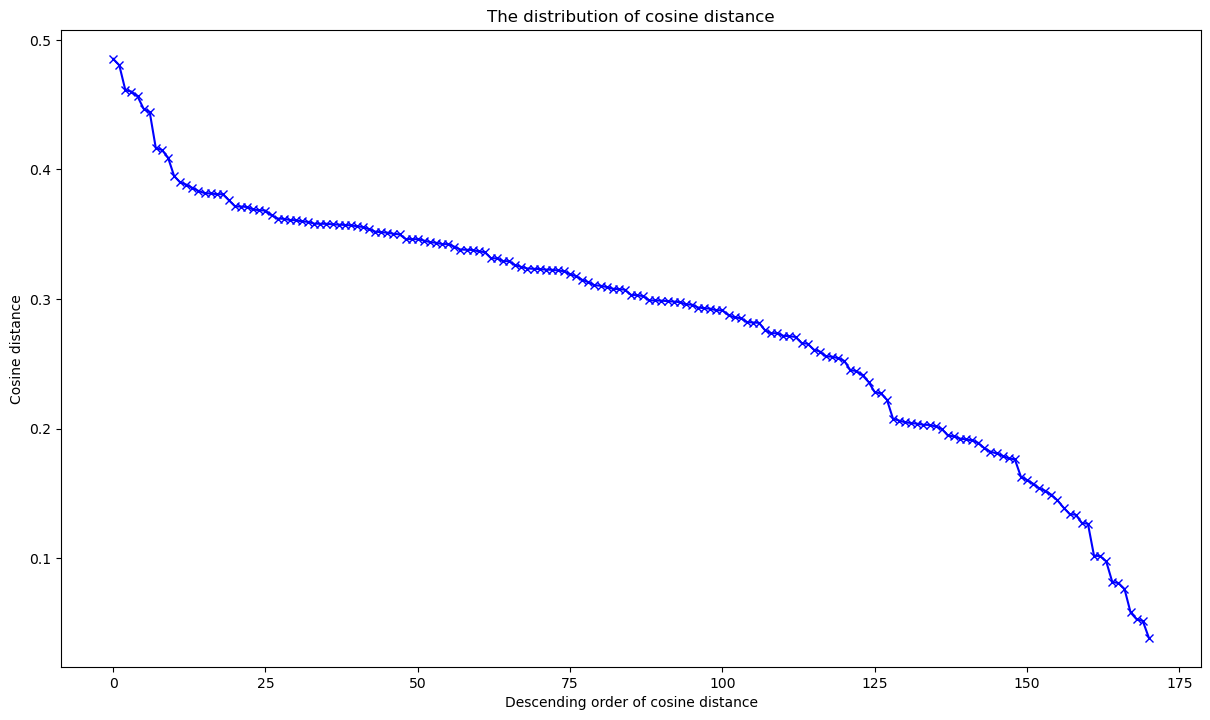

In [34]:

plt.plot(cosine_list_dedup, 'bx-')
plt.xlabel('Descending order of cosine distance')
plt.ylabel('Cosine distance')
plt.title('The distribution of cosine distance')
plt.show()

In [35]:
list(raw_context_value_list.keys())

['Be choosing own goals_0',
 'Be choosing own goals_1',
 'Have wealth_0',
 'Have wealth_1',
 'Have a good reputation_0',
 'Have a good reputation_1',
 'Have a stable society_0',
 'Be compliant_0',
 'Be compliant_1',
 'Be helpful_0',
 'Have the own family secured_0',
 'Have the own family secured_1',
 'Have the own family secured_2',
 'Have the own family secured_3',
 'Be broadminded_0',
 'Be broadminded_1',
 'Be broadminded_2',
 'Have an objective view_0',
 'Have an objective view_1']

In [36]:
order=['Be choosing own goals_0',
 'Have wealth_0',
 'Have an objective view_1',
 'Be choosing own goals_1',
 'Have the own family secured_0',
 'Have a good reputation_0',
 'Have a stable society_0',
 'Have the own family secured_2',
 'Be broadminded_2',
 'Be compliant_1',
 'Be broadminded_1',
 'Have wealth_1',
 'Be broadminded_0',
'Have a good reputation_1',
'Be helpful_0',
 'Be compliant_0',
 'Have the own family secured_1',
 'Have the own family secured_3',
 'Have an objective view_0'
]

In [37]:
cosine_list_ordered= cosine_list[order].copy()


In [38]:
cosine_list_ordered=cosine_list_ordered.loc[order]

<Axes: ylabel='index'>

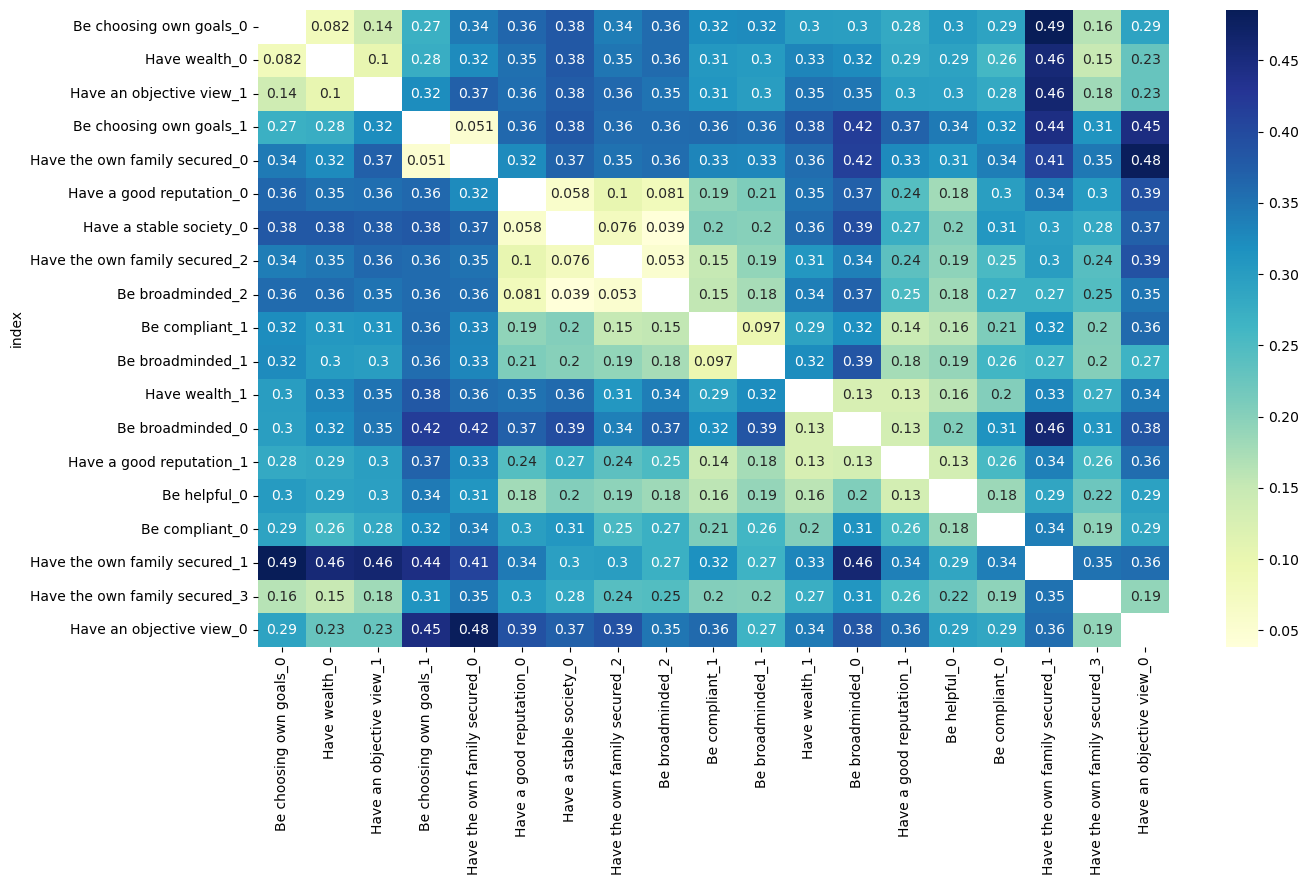

In [39]:
rcParams['figure.figsize'] = 14.7,8.27
sb.heatmap(cosine_list_ordered,
           #yticklabels=raw_context_value_list.keys(), 
           #xticklabels=raw_context_value_list.keys(), 
           cmap="YlGnBu",
          annot=True)

In [40]:
list_index=list(raw_context_value_list.keys())
list_value=[]
list_keywords=[]
list_representations=[]
list_value_l2=[]
for i in list_index:
    print(i)
    list_value.append(list(raw_context_value_list[i][0]))
    list_keywords.append(list(raw_context_value_list[i][1]))
    list_representations.append(list(raw_context_value_list[i][2]))
    list_value_l2.append(list(raw_context_value_list[i][3]))

Be choosing own goals_0
Be choosing own goals_1
Have wealth_0
Have wealth_1
Have a good reputation_0
Have a good reputation_1
Have a stable society_0
Be compliant_0
Be compliant_1
Be helpful_0
Have the own family secured_0
Have the own family secured_1
Have the own family secured_2
Have the own family secured_3
Be broadminded_0
Be broadminded_1
Be broadminded_2
Have an objective view_0
Have an objective view_1


In [41]:
raw_context_value_df=pd.DataFrame()
raw_context_value_df['index']=raw_context_value_list.keys()
raw_context_value_df=raw_context_value_df.set_index('index')
raw_context_value_df['value']=list_value
raw_context_value_df['keywords']=list_keywords
raw_context_value_df['representations']=list_representations
raw_context_value_df['value_l2']=list_value_l2
raw_context_value_df['count']=value_count

In [42]:
raw_context_value_df.loc[order]

,value,keywords,representations,value_l2,count
index,,,,,
Be choosing own goals_0,[Be choosing own goals],"[economy, meter, company, work, economic, meas...","[This action doe n't open the door , but give ...",[Self-direction: action],49
Have wealth_0,[Have wealth],"[economy, impact, company, income, customer, s...","[My girlfriend work in physiotherapy . Here , ...",[Power: resources],38
Have an objective view_1,[Have an objective view],"[economy, income, job, future, sector, track, ...",[The economy need to be restarted a soon a pos...,[Universalism: objectivity],46
Be choosing own goals_1,[Be choosing own goals],"[glove, physiotherapist, business, dentist, eq...",[This measure also cause only a small increase...,[Self-direction: action],53
Have the own family secured_0,[Have the own family secured],"[glove, physiotherapist, contact, customer, eq...",[This measure also cause only a small increase...,[Benevolence: caring],90
Have a good reputation_0,[Have a good reputation],"[loneliness, elderly, family, contact, residen...",[Because of the loneliness of the resident of ...,[Face],133
Have a stable society_0,[Have a stable society],"[loneliness, suffering, elderly, family, care,...",[Because of the loneliness of the resident of ...,[Security: societal],572
Have the own family secured_2,[Have the own family secured],"[loneliness, elderly, care, resident, health, ...",[This measure will undoubtedly lead to a very ...,[Benevolence: caring],71
Be broadminded_2,[Be broadminded],"[loneliness, elderly, family, care, death, ris...",[Because of the loneliness of the resident of ...,[Universalism: tolerance],87


In [43]:
raw_context_value_df.loc[order].to_csv('draft_list.csv')